In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
def import_metrics_json(models_path, run_num):
    """
    Looks in {models_path}/{run_num}/metrics.json and returns the contents as a
    Python dictionary. Returns None if the path does not exist.
    """
    path = os.path.join(models_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

In [3]:
def get_best_metric(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value to use for
    comparison. The best metric value is determined by `metric_compare_func`, which
    must take in two arguments, and return whether or not the _first_ one is better.
    Returns the number of the run, the value associated with that run, and a dict of
    all the values used for comparison.
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_val, all_vals = None, None, {}
    for run_num in metrics.keys():
        try:
            val = reduce_func(metrics[run_num][metric_name]["values"])
            all_vals[run_num] = val
            if best_val is None or compare_func(val, best_val):
                best_val, best_run = val, run_num
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_val, all_vals

In [4]:
def get_best_metric_at_best_epoch(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value FOR EACH
    SUBARRAY/VALUE in the value array to use for comparison. The best metric value
    is determined by `metric_compare_func`, which must take in two arguments, and
    return whether or not the _first_ one is better.
    Returns the number of the run, the (one-indexed) number of the epch, the value
    associated with that run and epoch, and a dict of all the values used for
    comparison (mapping pair of run number and epoch number to value).
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_epoch, best_val, all_vals = None, None, None, {}
    for run_num in metrics.keys():
        try:
            # Find the best epoch within that run
            best_epoch_in_run, best_val_in_run = None, None
            for i, subarr in enumerate(metrics[run_num][metric_name]["values"]):
                val = reduce_func(subarr)
                if best_val_in_run is None or compare_func(val, best_val_in_run):
                    best_epoch_in_run, best_val_in_run = i + 1, val
            all_vals[(run_num, best_epoch_in_run)] = best_val_in_run
            
            # If the best value in the best epoch of the run is best so far, update
            if best_val is None or compare_func(best_val_in_run, best_val):
                best_run, best_epoch, best_val = run_num, best_epoch_in_run, best_val_in_run
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_epoch, best_val, all_vals

In [5]:
def print_validation_profile_and_prior_losses(condition):
    models_path = "/users/amtseng/att_priors/models/trained_models/profile_models/%s/" % condition
    
    print("Best profile loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_prof_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.2f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["train_prof_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["val_prof_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.4f" % i for i in np.mean(metrics["val_att_losses"]["values"], axis=1)]))
    return all_vals

In [6]:
noprior_vals = print_validation_profile_and_prior_losses("HepG2")

Best profile loss overall:
	Best run: 4
	Best epoch in run: 10
	Associated value: 179.99440738677978
Best epoch in each run:
	Run 1, epoch 10: 180.97
	Run 2, epoch 8: 180.73
	Run 3, epoch 7: 180.46
	Run 4, epoch 10: 179.99
	Run 5, epoch 10: 180.05
	Run 6, epoch 9: 180.83
All validation profile and prior losses:
1
	200.36 194.65 193.33 192.59 192.15 191.83 191.66 191.52 191.40 191.25
	184.69 182.63 181.86 181.45 181.32 181.37 181.15 181.13 181.09 180.97
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
2
	199.41 194.43 193.20 192.45 192.04 191.73 191.50 191.35 191.22 191.14
	184.60 182.48 181.70 181.30 180.91 180.93 180.88 180.73 180.80 180.90
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
3
	198.70 193.95 192.49 191.83 191.42 191.19 191.02 190.83 190.75 190.59
	183.93 181.95 181.27 180.81 180.70 180.67 180.46 180.62 180.62 180.83
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
4
	199.55 194.49 193.11 192.40 192.02 191.

In [7]:
prior_vals = print_validation_profile_and_prior_losses("HepG2_prior")

Best profile loss overall:
	Best run: 3
	Best epoch in run: 7
	Associated value: 181.0568891398112
Best epoch in each run:
	Run 1, epoch 9: 181.77
	Run 2, epoch 9: 181.86
	Run 3, epoch 7: 181.06
	Run 4, epoch 10: 181.13
	Run 5, epoch 7: 181.82
All validation profile and prior losses:
1
	199.37 194.95 194.05 193.47 193.14 192.86 192.67 192.56 192.45 192.38
	184.64 183.46 182.80 182.50 182.20 182.05 182.10 182.17 181.77 182.11
	0.1124 0.0946 0.0776 0.0777 0.0766 0.0789 0.0812 0.0818 0.0797 0.0826
2
	199.63 195.21 194.34 193.89 193.69 193.50 193.34 193.15 193.09 192.99
	184.50 183.09 183.09 182.21 182.38 182.05 182.14 182.13 181.86 181.90
	0.1013 0.0823 0.0744 0.0758 0.0762 0.0742 0.0755 0.0810 0.0776 0.0781
3
	199.85 195.26 194.04 193.39 193.00 192.85 192.69 192.56 192.47 192.40
	184.08 182.69 182.14 181.53 181.53 181.49 181.06 181.22 181.28 181.22
	0.0980 0.0929 0.0930 0.0843 0.0784 0.0846 0.0813 0.0852 0.0845 0.0822
4
	199.82 195.20 194.24 193.80 193.51 193.30 193.10 192.91 192.76 192.

In [9]:
def print_validation_and_prior_losses(condition):
    models_path = "/users/amtseng/att_priors/models/trained_models/binary_models/%s/" % condition
    
    print("Best validation loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.3f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["train_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["val_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["val_att_losses"]["values"], axis=1)]))
    return all_vals

In [11]:
noprior_vals = print_validation_and_prior_losses("HepG2")

Best validation loss overall:
	Best run: 7
	Best epoch in run: 1
	Associated value: 0.23903661345442137
Best epoch in each run:
	Run 1, epoch 1:  0.260
	Run 2, epoch 1:  0.261
	Run 3, epoch 1:  0.242
	Run 4, epoch 1:  0.252
	Run 5, epoch 1:  0.243
	Run 6, epoch 1:  0.244
	Run 7, epoch 1:  0.239
	Run 8, epoch 1:  0.241
	Run 9, epoch 1:  0.244
	Run 10, epoch 1:  0.239
	Run 11, epoch 1:  0.254
	Run 12, epoch 1:  0.247
	Run 13, epoch 1:  0.242
	Run 14, epoch 1:  0.240
	Run 15, epoch 1:  0.243
	Run 16, epoch 1:  0.245
	Run 17, epoch 1:  0.254
	Run 18, epoch 1:  0.241
	Run 19, epoch 1:  0.242
	Run 20, epoch 1:  0.242
	Run 21, epoch 1:  0.255
	Run 22, epoch 1:  0.249
	Run 23, epoch 1:  0.242
	Run 24, epoch 1:  0.245
	Run 25, epoch 1:  0.247
	Run 26, epoch 1:  0.257
	Run 27, epoch 1:  0.255
	Run 28, epoch 1:  0.253
All validation profile and prior losses:
1
	 0.249  0.194  0.166  0.146  0.129  0.115  0.105  0.098  0.092  0.088
	 0.260  0.274  0.300  0.341  0.356  0.375  0.403  0.432  0.435  0.

In [14]:
prior_vals = print_validation_and_prior_losses("HepG2_prior")

Best validation loss overall:
	Best run: 5
	Best epoch in run: 5
	Associated value: 0.2355518709279989
Best epoch in each run:
	Run 1, epoch 5:  0.248
	Run 2, epoch 8:  0.251
	Run 3, epoch 9:  0.251
	Run 4, epoch 8:  0.248
	Run 5, epoch 5:  0.236
	Run 6, epoch 2:  0.252
	Run 7, epoch 7:  0.267
	Run 8, epoch 5:  0.251
	Run 9, epoch 4:  0.242
	Run 10, epoch 3:  0.310
All validation profile and prior losses:
1
	 0.329  0.288  0.272  0.247  0.219  0.201  0.188  0.175  0.175  0.178
	 0.322  0.293  0.302  0.262  0.248  0.254  0.261  0.268  0.268  0.272
	 0.079  0.068  0.081  0.041  0.035  0.035  0.032  0.030  0.074  0.044
2
	 0.336  0.331  0.300  0.274  0.247  0.226  0.210  0.198  0.190  0.182
	 0.317  0.391  0.305  0.284  0.281  0.256  0.252  0.251  0.257  0.271
	 0.066  0.082  0.061  0.052  0.051  0.046  0.044  0.045  0.045  0.076
3
	 0.330  0.289  0.275  0.269  0.268  0.249  0.241  0.224  0.211  0.198
	 0.328  0.289  0.275  0.306  0.278  0.277  0.258  0.256  0.251  0.251
	 0.067  0.055  0

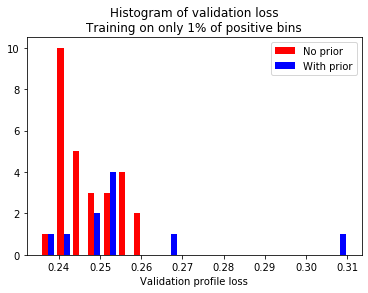

In [15]:
bin_num = 20
plt.figure()
plt.hist(
    [np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"])
title = "Histogram of validation loss"
title += "\nTraining on only 1% of positive bins"
plt.title(title)
plt.xlabel("Validation profile loss")
plt.legend()

In [36]:
np_vals, p_vals = np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))
t, p = scipy.stats.ttest_ind(np_vals, p_vals)
print(t)
print(p / 2)

-4.2640587687389155
5.566017270666034e-05
